# Members

## Cham An Fam
## Simon Idoko
## Ruslan Damindarov

# Imports

In [1]:
import numpy as np
from math import atan2, cos, sin
import matplotlib.pyplot as plt
from sympy import symbols, trigsimp, Matrix, lambdify, diff, init_printing
import sympy as sym

In [2]:
np.set_printoptions(precision=2, suppress=True, linewidth=200)

# Utilities

In [3]:
# Utilities for Forward and Inverse Kinematics
def Rx(q):
    T = np.array([[1,         0,          0, 0],
                  [0, np.cos(q), -np.sin(q), 0],
                  [0, np.sin(q),  np.cos(q), 0],
                  [0,         0,          0, 1]], dtype=float)
    return T


def dRx(q):
    T = np.array([[0,          0,          0, 0],
                  [0, -np.sin(q), -np.cos(q), 0],
                  [0,  np.cos(q), -np.sin(q), 0],
                  [0,          0,          0, 0]], dtype=float)
    return T


def Ry(q):
    T = np.array([[ np.cos(q), 0, np.sin(q), 0],
                  [         0, 1,         0, 0],
                  [-np.sin(q), 0, np.cos(q), 0],
                  [         0, 0,         0, 1]], dtype=float)
    return T


def dRy(q):
    T = np.array([[-np.sin(q), 0,  np.cos(q), 0],
                  [         0, 0,          0, 0],
                  [-np.cos(q), 0, -np.sin(q), 0],
                  [         0, 0,          0, 0]], dtype=float)
    return T


def Rz(q):
    T = np.array([[np.cos(q), -np.sin(q), 0, 0],
                  [np.sin(q),  np.cos(q), 0, 0],
                  [        0,          0, 1, 0],
                  [        0,          0, 0, 1]], dtype=float)
    return T


def dRz(q):
    T = np.array([[-np.sin(q), -np.cos(q), 0, 0],
                  [ np.cos(q), -np.sin(q), 0, 0],
                  [         0,          0, 0, 0],
                  [         0,          0, 0, 0]], dtype=float)
    return T


def Tx(x):
    T = np.array([[1, 0, 0, x],
                  [0, 1, 0, 0],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTx(x):
    T = np.array([[0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Ty(y):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, y],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTy(y):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0],
                  [0, 0, 0, 0]], dtype=float)
    return T


def Tz(z):
    T = np.array([[1, 0, 0, 0],
                  [0, 1, 0, 0],
                  [0, 0, 1, z],
                  [0, 0, 0, 1]], dtype=float)
    return T


def dTz(z):
    T = np.array([[0, 0, 0, 0],
                  [0, 0, 0, 0],
                  [0, 0, 0, 1],
                  [0, 0, 0, 0]], dtype=float)
    return T

# Virtual Joint Modelling

### Parameters:

In [4]:
d = 0.15
K_a = 10**6
params = { 'A':np.pi*(d**2)/4, 'E':70*10**9, 'G':25.2*10**9, 'l':1, 'Ix':np.pi*(d**4)/64, 'Iy':np.pi*(d**4)/64, 'Iz':np.pi*(d**4)/64, 'Ip':np.pi*(d**4)/32}

In [5]:
l1 = l2= 1
l3 = 0.1
d1 = 1

# Robot Height, Width and Breadth
h, w, b = 1, 1, 1

# Robot leg base transformations
T_base_leg_z = np.eye(4, dtype=float) 
T_base_leg_y = np.linalg.multi_dot([ Tz(h), Rx(-np.pi/2) ])
T_base_leg_x = np.linalg.multi_dot([Ty(w), Ry(np.pi/2), Rz(np.pi)])
T_base = np.array([T_base_leg_x, T_base_leg_y, T_base_leg_z])

# Robot tool transformations
T_tool_z = np.eye(4, dtype=float)
T_tool_y = np.transpose(Rx(-np.pi/2))
T_tool_x = np.transpose(np.linalg.multi_dot([Ry(np.pi/2), Rz(np.pi)]))
T_tool = [T_tool_x, T_tool_y, T_tool_z]


In [6]:
theta = np.zeros(13, dtype=float)
thetas = [theta, theta, theta]

### Kinematics

#### Forward

In [7]:
# Forward Kinematics for a 6 D.O.F robot
def T_3D(thetas):
  T_3D = np.linalg.multi_dot([Tx(thetas[0]), Ty(thetas[1]), Tz(thetas[2]), Rx(thetas[3]), Ry(thetas[4]), Rz(thetas[5])])
  return T_3D

In [8]:
# Get Forward Kinematics for a single leg
def FK_vjm(q1, q2, q3, theta, T_base, T_tool, i):
  # d1 - active joint variable
  # q1, q2, q3 - passive joint variables
  # theta - virtual joint variables (13 elements)

  if i is 2:
    T_platform = Tx(l3)
  elif i is 1:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(-l3*cos(np.pi/6))])
  elif i is 0:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(l3*cos(np.pi/6))])

  T = np.linalg.multi_dot([Tz(d1),            # active joint
                           Tz(theta[0]),      # virtual spring
                           Rz(q1),            # passive joint
                           Tx(l1),            # rigid link
                           T_3D(theta[1:7]),  # virtual spring
                           Rz(q2),            # passive joint
                           Tx(l2),            # rigid link
                           T_3D(theta[7:13]), # virtual spring
                           Rz(q3)            # passive joint
                           ])  
  T_total = np.linalg.multi_dot([T_base, T, T_tool, T_platform])
  return T_total

In [9]:
# Get the total Forward Kinematics for each leg 
def FK_vjm_Tripteron(q_list, thetas, T_base, T_tool):
  T_total = []
  # print(q_list)
  for i in range(3):
    q1, q2, q3 = q_list[i]
    T_total.append(FK_vjm(q1, q2, q3, thetas[i], T_base[i], T_tool[i], i))
    
  return T_total

#### Inverse

In [10]:
# Returns the join parameter variable, i.e. Inverse Kinematics of a single leg
def IK_Leg(T_base, pos__g, i, link_params={'L':1}):
  """Pos_e_g represents the global position of the end effector"""
  
  l1 = link_params['L']
  l2 = l1

  x, y, z = pos__g[:3]

  # start
  T = np.array([[1, 0, 0, x],                
                [0, 1, 0, y],
                [0, 0, 1, z],
                [0, 0, 0, 1]])
  
  if i is 2:
    T_platform = np.linalg.inv(Tx(l3))
  elif i is 1:
    T_platform = np.linalg.multi_dot([np.linalg.inv(Ty(-l3*cos(np.pi/6))), np.linalg.inv(Tx(-l3*sin(np.pi/6)))])
  elif i is 0:
    T_platform = np.linalg.multi_dot([np.linalg.inv(Ty(l3*cos(np.pi/6))), np.linalg.inv(Tx(-l3*sin(np.pi/6)))])
  
  # if i is 2:
  #   T_platform = np.linalg.multi_dot([np.linalg.inv(Ty(l3*cos(np.pi/6))), 
  #                                     np.linalg.inv(Tx(-l3*sin(np.pi/6))) 
  #                                     ])
  # elif i is 0:
  #   T_platform = np.linalg.inv(Tx(l3))
  # elif i is 1:
  #   T_platform = np.linalg.multi_dot([np.linalg.inv(Ty(-l3*cos(np.pi/6))), 
  #                                     np.linalg.inv(Tx(-l3*sin(np.pi/6))) 
  #                                     ])
    
  # Transformations in the local frame
  T_local = np.linalg.multi_dot([np.linalg.inv(T_base), 
                                 T,
                                 T_platform,
                                 np.linalg.inv(T_tool[i]),
                                 ])

  xe, ye = T_local[0,3], T_local[1,3]
  # end

  # R_base = T_base[0:3, 0:3]
  # p_base = T_base[0:3, 3]
  # pos__loc = np.transpose(R_base).dot(pos__g - p_base)

  # x, y, z = pos__loc[:3]
  
  # if i is 0:
  #   xe = x - l3
  #   ye = y
  # elif i is 1:
  #   xe = x + l3*sin(np.pi/6) 
  #   ye = y + l3*cos(np.pi/6)
  # elif i is 2:
  #   xe = x + l3*sin(np.pi/6)
  #   ye = y - l3*cos(np.pi/6)

  D = (xe**2 + ye**2 - l1**2 - l2**2)/(2*l1*l2)
  cos_q2 = D
  sin_q2 = np.sqrt(1 - D**2)

  q2 = atan2(sin_q2, cos_q2)
  q1 = atan2(ye, xe) - atan2(l2*sin_q2, l1 + l2*cos_q2)
  q3 = -q1 - q2

  q = q1, q2, q3

  return np.asarray(q)

In [11]:
# Returns the inverse kinematics for all the joint parameters of the robot, given the bases of the legs and the end effector position
def IK_Tripetron(T_base, pos__g):
  q_total = []
  i = 0
  for T_b in T_base:
    q = IK_Leg(T_b, pos__g, i)
    q_total.append(q)
    i = i + 1
  
  return np.asarray(q_total)

#### Jacobian

In [12]:
# Forward Kinematics differential for a 6 D.O.F robot
def T_3D_diff(num, theta):
  if num is 1:
    return np.linalg.multi_dot([dTx(theta[0]), Ty(theta[1]), Tz(theta[2]), Rx(theta[3]), Ry(theta[4]), Rz(theta[5])])
  elif num is 2:
    return np.linalg.multi_dot([Tx(theta[0]), dTy(theta[1]), Tz(theta[2]), Rx(theta[3]), Ry(theta[4]), Rz(theta[5])])
  elif num is 3:
    return np.linalg.multi_dot([Tx(theta[0]), Ty(theta[1]), dTz(theta[2]), Rx(theta[3]), Ry(theta[4]), Rz(theta[5])])
  elif num is 4:
    return np.linalg.multi_dot([Tx(theta[0]), Ty(theta[1]), Tz(theta[2]), dRx(theta[3]), Ry(theta[4]), Rz(theta[5])])
  elif num is 5:
    return np.linalg.multi_dot([Tx(theta[0]), Ty(theta[1]), Tz(theta[2]), Rx(theta[3]), dRy(theta[4]), Rz(theta[5])])
  elif num is 6:
    return np.linalg.multi_dot([Tx(theta[0]), Ty(theta[1]), Tz(theta[2]), Rx(theta[3]), Ry(theta[4]), dRz(theta[5])])

In [13]:
# Returns the Jacobian with respect to the virtual joint 
def Jacobian_virtual(q1, q2, q3, theta, T_base, T_tool, H, i):
  # H - FK of the Tripteron
  # H = FK_vjm_Tripteron(q1, q2, q3, thetas, T_base, T_tool)
  H = np.asarray(H)
  R = H[0:3, 0:3]
  R = np.linalg.inv(R)
  R_prime = np.hstack([R, [[0], [0], [0]] ])
  
  R_prime = np.vstack([R_prime, [0, 0, 0, 1]])
  
  if i is 2:
    T_platform = Tx(l3)
  elif i is 1:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(-l3*cos(np.pi/6))])
  elif i is 0:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(l3*cos(np.pi/6))])

  J = []

  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  dTz(theta[0]),            # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                   # passive joint
                                  T_platform
                                  ])  
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J1 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])

  # for i in range(1,7):
  #   Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
  #                                   Tz(theta[0]),             # virtual spring
  #                                   Rz(q1),                   # passive joint
  #                                   Tx(l1),                   # rigid link
  #                                   T_3D_diff(i, theta[1:7]), # virtual spring
  #                                   Rz(q2),                   # passive joint
  #                                   Tx(l2),                   # rigid link
  #                                   T_3D(theta[7:13]),        # virtual spring
  #                                   Rz(q3)                    # passive joint
  #                                   ]) 
  #   Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  #   J_16 = np.vstack([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  #   J.append(J_16)
  
  # for i in range(1,7):
  #   Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
  #                                   Tz(theta[0]),             # virtual spring
  #                                   Rz(q1),                   # passive joint
  #                                   Tx(l1),                   # rigid link
  #                                   T_3D(theta[1:7]),         # virtual spring
  #                                   Rz(q2),                   # passive joint
  #                                   Tx(l2),                   # rigid link
  #                                   T_3D_diff(i, theta[7:13]),# virtual spring
  #                                   Rz(q3)                    # passive joint
  #                                   ]) 
  #   Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  #   J_713 = np.vstack([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  #   J.append(J_713)
  # J = np.asarray(J)
  # J.reshape(13,6) # size 13*6
  # return J
  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(1, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J2 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  

  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(2, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J3 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])

  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(3, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J4 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])


  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(4, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J5 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  

  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(5, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J6 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])


  Td_local = np.linalg.multi_dot([Tz(d1),            # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D_diff(6, theta[1:7]), # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J7 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])


  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(1, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J8 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])


  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(2, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J9 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])  


  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(3, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J10 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])



  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(4, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J11 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])  



  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(5, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J12 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])



  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D_diff(6, theta[7:13]),# virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ]) 
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J13 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]]) 

  J = np.transpose(np.vstack([J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13]))   
  return J

In [14]:
# Returns the Jacobian with respect to the virtual joint for the 3 robot legs
def Jacobian_virtual_total(q_list, thetas, T_base, T_tool, H ):
  # H - FK of the Tripteron
  H = FK_vjm_Tripteron(q_list, thetas, T_base, T_tool)
  J_total = []
  for i in range(3):
    q1, q2, q3 = q_list[i]
    J_total.append(Jacobian_virtual(q1, q2, q3, thetas[i], T_base[i], T_tool[i], H[i], i))
  return J_total

In [15]:
# Returns the Jacobian with respect to the passive joint
def Jacobian_passive(q1, q2, q3, theta, T_base, T_tool, H, i):
  # H - FK of the Tripteron
  # H = FK_vjm_Tripteron(np.asarray([q1, q2, q3]), thetas, T_base, T_tool)
  H = np.asarray(H)
  R = H[0:3, 0:3]
  R = np.linalg.inv(R)
  R_prime = np.hstack([R, [[0], [0], [0]] ])
  
  R_prime = np.vstack([R_prime, [0, 0, 0, 1]])

  if i is 2:
    T_platform = Tx(l3)
  elif i is 1:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(-l3*cos(np.pi/6))])
  elif i is 0:
    T_platform = np.linalg.multi_dot([Tx(-l3*sin(np.pi/6)), Ty(l3*cos(np.pi/6))])

  ## first joint ##
  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  dRz(q1),                  # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ])  
  
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J1 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])


  ## second joint ##
  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  dRz(q2),                  # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  Rz(q3),                    # passive joint
                                  T_platform
                                  ])  
          
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J2 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  

  ## third joint ##
  Td_local = np.linalg.multi_dot([Tz(d1),                   # active joint
                                  Tz(theta[0]),             # virtual spring
                                  Rz(q1),                   # passive joint
                                  Tx(l1),                   # rigid link
                                  T_3D(theta[1:7]),         # virtual spring
                                  Rz(q2),                   # passive joint
                                  Tx(l2),                   # rigid link
                                  T_3D(theta[7:13]),        # virtual spring
                                  dRz(q3),                   # passive joint
                                  T_platform
                                  ])
  
  Td_global = np.linalg.multi_dot([T_base, Td_local, T_tool, R_prime])
  J3 = np.block([Td_global[0, 3], Td_global[1, 3], Td_global[2, 3], Td_global[2, 1], Td_global[0, 2], Td_global[1, 0]])
  
          
  J = np.transpose(np.vstack([J1, J2, J3]))
  return J  

In [16]:
# Returns the Jacobian with respect to the passive joint for the 3 robot legs
def Jacobian_passive_total(q_list, thetas, T_base, T_tool, H ):
  # H - FK of the Tripteron
  H = FK_vjm_Tripteron(q_list, thetas, T_base, T_tool)
  J_total = []
  for i in range(3):
    q1, q2, q3 = q_list[i]
    J_total.append(Jacobian_passive(q1, q2, q3, thetas[i], T_base[i], T_tool[i], H[i], i))
  return J_total

### VJM

In [17]:
# Function that returns the K22 Stiffness matrix for a link given the link parameters and the Rotation relative to the global origin
def K_22(params):
  a, e, G, l, I_x, I_y, I_z, I_p = params['A'], params['E'], params['G'], params['l'], params['Ix'],params['Iy'], params['Iz'], params['Ip']
  k = np.array([
          [ (a*e)/l,  0,                0,                0,            0,                0               ],
          [ 0,        (12*e*I_z)/l**3,  0,                0,            0,                -(6*e*I_z)/l**2 ],
          [ 0,        0,                (12*e*I_y)/l**3,  0,            (6*e*I_y)/l**2,   0               ],
          [ 0,        0,                0,                (G*I_p)/l,    0,                0               ],
          [ 0,        0,                (6*e*I_y)/l**2,   0,            (4*e*I_y)/l,      0               ],
          [ 0,        -(6*e*I_z)/l**2,  0,                0,            0,                (4*e*I_z)/l     ]
  ]) 
  return k

In [18]:
# Returns a 13 X 13 matrix representing the 
def KTheta(params):
    K0 = np.zeros(13, dtype=float)
    K0[0] = K_a

    zeros_6_1 = np.zeros((6,1), dtype=float)
    zeros_6_6 = np.zeros((6,6), dtype=float)

    K1 = K_22(params)
    K1 = np.hstack([zeros_6_1, K1, zeros_6_6])

    K2 = K_22(params)
    K2 = np.hstack([zeros_6_1, zeros_6_6, K2])

    K = np.vstack([K0, K1, K2])
    return K

In [19]:
# Returns The K_c matric for the Robot for a specific joint parameters
def Kc_total(Ktheta, J_passive, J_virtual):
    Kc_total = []
    for i in range(3):
      # equation 11 from the paper
      # print(J_virtual[i])
      # print()     

      Kc0 = np.linalg.inv(np.linalg.multi_dot([J_virtual[i], np.linalg.inv(Ktheta), np.transpose(J_virtual[i])]))
      Kc_q = np.linalg.multi_dot([
                                  np.linalg.inv(np.linalg.multi_dot([np.transpose(J_passive[i]), np.linalg.inv(Kc0), J_passive[i]])), 
                                  np.transpose(J_passive[i]),
                                  np.linalg.inv(Kc0)
                                  ])
      
      # equation 12 in the paper
      Kc = Kc0 - np.linalg.multi_dot([
                                      Kc0,
                                      J_passive[i], 
                                      Kc_q
                                      ])
      Kc_total.append(Kc)
    
    Kc_total = Kc_total[0] + Kc_total[1] + Kc_total[2]
    return Kc_total

#### Deflection Data

In [20]:
# Get the total deflection given a specific wrench and joint parameter configuration
def deflection_total(q_list, thetas, H, We): # deflection for one point
  H = FK_vjm_Tripteron(q_list, thetas, T_base, T_tool)
  Kthetas = KTheta(params)
  J_passive = Jacobian_passive_total(q_list, thetas, T_base, T_tool, H )
  J_virtual = Jacobian_virtual_total(q_list, thetas, T_base, T_tool, H )

  Kc = Kc_total(Kthetas, J_passive, J_virtual)

  dt = np.linalg.inv(Kc).dot(We)
  return dt

In [21]:
# Robot Height, Width and Breadth
h, w, b = 1, 1, 1

# Function Calculates the total Deflections for all posible end_effector positions for a specific End Effector Wrench 
def get_wrench_deflection_plot_data(W_e=np.array([100, 0, 0, 0, 0, 0])):
  X = np.zeros((10,10,10))
  Y = np.zeros((10,10,10))
  Z = np.zeros((10,10,10))
  deflections = np.zeros((10, 10, 10))

  for z in np.arange(0.01, h, 0.1):
    for y in np.arange(0.01, w, 0.1):
      for x in np.arange(0.01, b, 0.1):
        # Inverse kinematics to get join variables
        # q_list= IK_Tripetron(T_base, np.array([ x-0.1, y-0.1, z-0.1])) # q1, q2, q3
        q_list= IK_Tripetron(T_base, np.array([ x, y, z])) # q1, q2, q3

        # print(q_list)
        # Total Robot deflection at current end_effector position
        H = FK_vjm_Tripteron(q_list, thetas, T_base, T_tool)
        dt_e = deflection_total(q_list, thetas, H, W_e)

       
        # Add to Matrices to be used to plot deflection map
        deflections[int(x*10)][int(y*10)][int(z*10)] = np.linalg.norm(dt_e[:3])
        X[int(x*10)][int(y*10)][int(z*10)] = x
        Y[int(x*10)][int(y*10)][int(z*10)] = y
        Z[int(x*10)][int(y*10)][int(z*10)] = z
  return [ X, Y, Z, deflections ]

#### Plots

In [22]:
space_x = 1
space_y = 1
space_z = 1

In [23]:
# Function to Plot the deflection Map
def plotDeflections(x, y, z, deflection, cmap, s, lim=False):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_xlim3d(0, space_x)
    ax.set_ylim3d(0, space_y)
    ax.set_zlim3d(0, space_z)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    r = [0,1]
    X, Y = np.meshgrid(r, r)
    ones = np.ones(4).reshape(2, 2)
    zeros = np.zeros(4).reshape(2, 2)
    ax.plot_wireframe(X,Y,ones, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,Y,zeros, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,zeros,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(X,ones,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(ones,X,Y, alpha=0.5, color='slategray')
    ax.plot_wireframe(zeros,X,Y, alpha=0.5, color='slategray')

    cmap = ax.scatter3D(x, y, z, c=deflection, cmap=cmap, s=s)
    if lim:
      cmap.set_clim(0.0011, 0.0014)
      
    plt.colorbar(cmap)
    plt.show()

#### Wrenches

##### Wrench along x [100, 0, 0, 0, 0, 0]

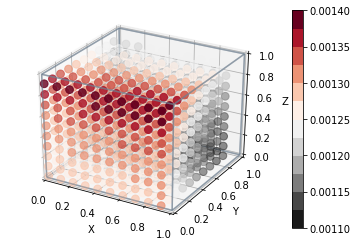

In [24]:
X, Y, Z, dts = get_wrench_deflection_plot_data(W_e=np.array([100, 0, 0, 0, 0, 0]))
cmap = plt.cm.get_cmap('RdGy_r', 12)
plotDeflections(X, Y, Z, dts, cmap, 60, True)

##### Difference Map between VJM and MSA Model with wrench in x - direction

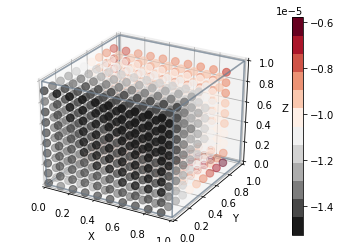

In [32]:
MSA_deflections = np.load("/content/x_wrench.npy")
plotDeflections(X, Y, Z, -dts+MSA_deflections, cmap, 60)

##### Wrench along y [0, 100, 0, 0, 0, 0]

In [31]:
# X, Y, Z, dts_y = get_wrench_deflection_plot_data(W_e=np.array([0, 100, 0, 0, 0, 0]))
# cmap = plt.cm.get_cmap('RdGy_r', 12)
# plotDeflections(X, Y, Z, dts_y, cmap, 60, True)

KeyboardInterrupt: ignored

In [27]:
# MSA_def_y = np.load("/content/y_wrench.npy")
# plotDeflections(X, Y, Z, dts_y+MSA_def_y, cmap, 60)

##### Wrench along z [0, 0, 100, 0, 0, 0]

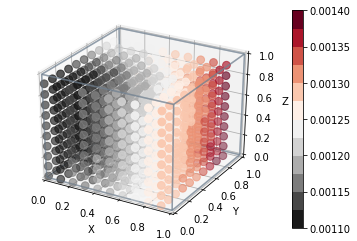

In [28]:
X, Y, Z, dts_z = get_wrench_deflection_plot_data(W_e=np.array([0, 0, 100, 0, 0, 0]))
cmap = plt.cm.get_cmap('RdGy_r', 12)
plotDeflections(X, Y, Z, dts_z, cmap, 60, True)

In [29]:
# MSA_def_z = np.load("/content/z_wrench.npy")
# plotDeflections(X, Y, Z, dts_z+MSA_def_z, cmap, 60)

In [30]:
# q1_init, q2_init, q3_init = IK_Tripetron(T_base, np.array([ 0.5, 0.5, 0.5 ]))

# space_x = 1
# space_y = 1
# space_z = 1

# fig = plt.figure()
# ax = plt.axes(projection='3d')
# # ax.set_xlim3d(0, space_x)
# # ax.set_ylim3d(0, space_y)
# # ax.set_zlim3d(0, space_z)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# colors = ["red","green","yellow"]

# for i in range(3):

#   toOrigin = T_base[i]
#   t = theta[i]
#   origin = toOrigin[0:3, 3]
#   T_active_1 = np.linalg.multi_dot([T_base[i], # T_base transform
#                                         Tz(0.5), # active joint
#                                         Tz(0)]) # 1 DOF virtual spring 
#   active1 = T_active_1[0:3, 3]

#   T_passive_1 = np.linalg.multi_dot([T_active_1, # transfrom to the active joint
#                                     Rz(q1_init[i])]) # passive joint
#   passive1 = T_passive_1[0:3, 3]

#   T_passive_2 = np.linalg.multi_dot([T_passive_1, # transform to the passive joint
#                                     Tx(l1), # rigid link
#                                     Tx(0), Ty(0), Tz(0), Rx(0), Ry(0), Rz(0), # 6 DOF virtual spring
#                                     Rz(q2_init[i])]) # passive joint
#   passive2 = T_passive_2[0:3, 3]

#   T_passive_3 = np.linalg.multi_dot([T_passive_2, # transform to the passive joint
#                                     Tx(l2), # rigid link
#                                     Tx(0), Ty(0), Tz(0), Rx(0), Ry(0), Rz(0), # 6 DOF virtual spring
#                                     Rz(q3_init[i])]) # passive joint
#   passive3 = T_passive_3[0:3, 3]

#   X = [active1[0], passive1[0], passive2[0], passive3[0]]
#   Y = [active1[1], passive1[1], passive2[1], passive3[1]]
#   Z = [active1[2], passive1[2], passive2[2], passive3[2]]
  
#   ax.plot3D(X, Y, Z, c='steelblue', linewidth=3)
#   ax.scatter3D(X, Y, Z, color =colors[i], s=100)

# plt.show()